# Circularity

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from auriga.images import add_redshift, figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.snapshot import Snapshot

In [6]:
figure_setup()

In [3]:
def load_subhalo_star_circ(simulation: str) -> np.ndarray:
    """
    This method returns the circularity of the stars in the main subhalo for
    a given simulation.

    Parameters
    ----------
    simulation : str
        The simulation to load.

    Returns
    -------
    np.ndarray
        The circularity.
    """
    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    return s.circularity[(s.type == 4) \
        & (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)]

In [4]:
def plot_circ_dist_for_galaxies(simulations: list,
                                n_bins: int = 150,
                                circ_range: tuple = (-2.0, 2.0)):
    fig = plt.figure(figsize=(2.0, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.grid(True, ls='-', lw=0.25, c='silver')
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(circ_range)
    # ax.set_ylim(-0.5, 5.5)
    ax.set_xticks([-2, -1, 0, 1, 2])
    # ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('$\epsilon$')
    ax.set_ylabel('PDF')

    for simulation in simulations:
        circularity = load_subhalo_star_circ(simulation=simulation)
        ax.hist(x=circularity,
                bins=n_bins,
                range=circ_range,
                histtype="step",
                density=True,
                label=simulation.upper())

    ax.legend(loc='upper left', ncol=1, framealpha=0, fontsize=6.0)

    plt.show()

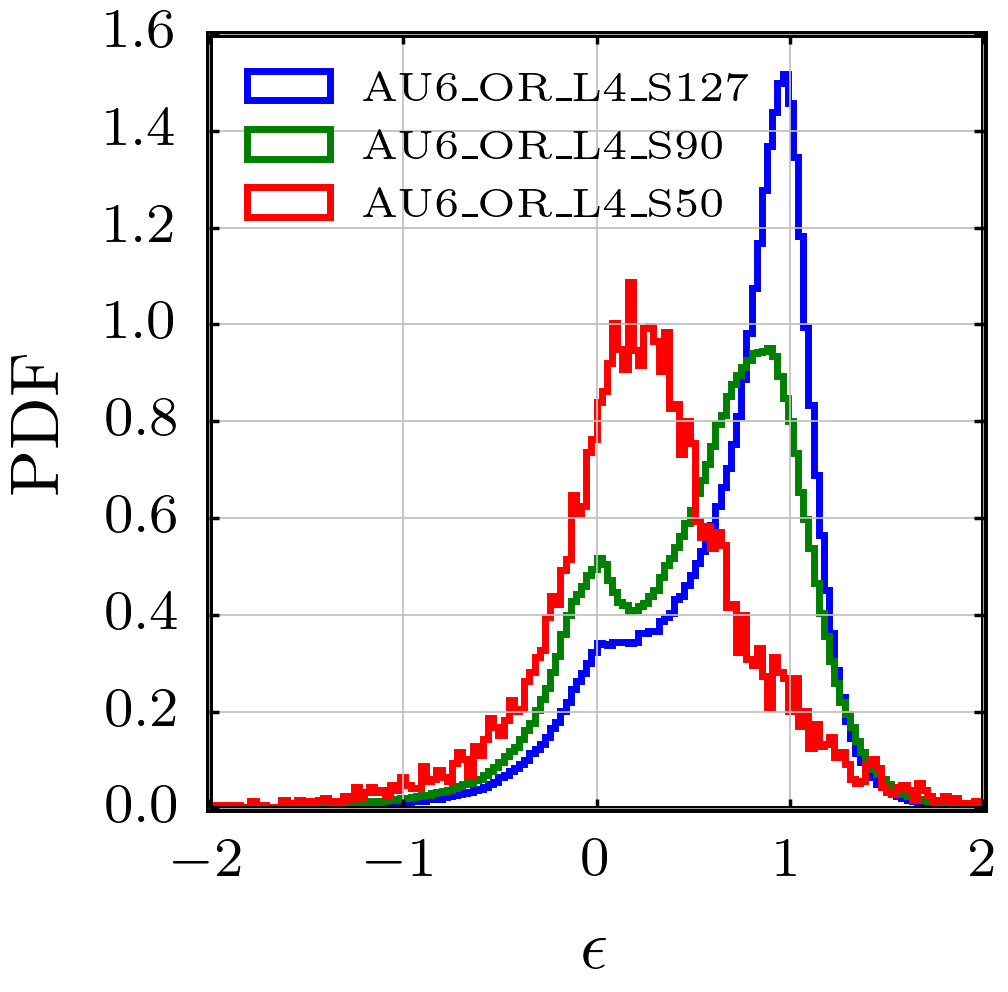

In [7]:
plot_circ_dist_for_galaxies(simulations=["au6_or_l4_s127",
                                         "au6_or_l4_s90",
                                         "au6_or_l4_s50"])